In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import skimage.filters as filters
import matplotlib.patches as mpatches

# Crear estructura de datos

Se genera una estructura de datos que simula la evolucion temporal de las imagenes (image_evol). Cada uno de los image_evol[i] es una imagen de un instante determinado. 

In [160]:
def distance(x,y,npx,npy):
    D=np.zeros((npx,npy))
    for i in range (D.shape[0]):
        for j in range (D.shape[1]):
            D[i,j]=np.sqrt((x-i)**2+(y-j)**2)
    return D    

def cluster_pixels(npixels,x,y,npx,npy):
    D=distance(x,y,npx,npy)
    pixels=np.zeros((1,2))
    for i in range (int(npixels)):
        xi=np.where(D==np.min(D))[0][0]
        yi=np.where(D==np.min(D))[1][0]
        pixels=np.vstack((pixels,[xi,yi]))
        D[xi,yi]=1e6
    pixels=np.delete(pixels,0,0)
    return pixels


def Add_cluster(n,Data,pxcapacity):
    npx,npy=Data.shape[0],Data.shape[1]
    x,y=npx*np.random.rand(),npy*np.random.rand()
    npixels=np.ceil(n/pxcapacity)
    pxs=cluster_pixels(npixels,x,y,npx,npy)
    n_rest=n
    for px in pxs:
        if n_rest>=pxcapacity:
            Data[int(px[0]),int(px[1])]+=pxcapacity
            n_rest-=pxcapacity
        else:
            Data[int(px[0]),int(px[1])]+=n_rest
    return Data

def Initial_distribution(Nclusters,Max_size=100,pxcapacity=2,npx=100,npy=100):
    distr=np.zeros((npx,npy))
    for i in range(Nclusters):
        n=np.random.rand()*Max_size//1
        distr=Add_cluster(n,distr,pxcapacity)
    return distr


def evolve(D,p):
    for i in range(distr.shape[0]):
        for j in range(distr.shape[1]):
            n0=D[i,j]
            ndie=0
            for ni in range (int(n0)):
                r=np.random.rand()
                if r<p:
                    ndie+=1
            D[i,j]-=ndie
    return D

def temporal_evolution(distr,p,Nt):
    data0=np.zeros_like(distr)
    data=np.stack((data0,distr))
    d=distr
    for i in range (Nt):
        d=evolve(d,p)
        data=np.append(data,[d],axis=0)
    data=np.delete(data,0,0)
    return data     

def images(data,noise=1,brightness=2):
    n0,n1,n2=data.shape[0],data.shape[1],data.shape[2]
    image_evol=data*brightness+noise*np.random.normal(0,noise, size=(n0,n1,n2))
    return image_evol

In [173]:
distr=Initial_distribution(20,Max_size=30,npx=50,npy=50)

In [174]:
data=temporal_evolution(distr,0.05,100)

In [175]:
image_evol=images(data,1)

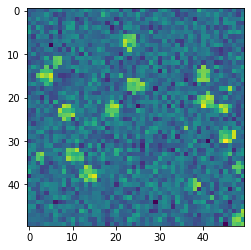

In [176]:
plt.imshow(image_evol[0])

# Analizar evolucion de los spots

In [177]:
def ROI(im,mask):
    label_image = label(mask)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(im)
    rois=np.array([0,0,0,0])
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        rois=np.vstack((rois,[minc,minr,maxc,maxr]))
    rois=np.delete(rois,0,0)
    return rois

In [178]:
def Apply_thresh(im,thresh):
    mask=im>thresh
    return mask

In [179]:
def cluster(rois,image_evol,number,ti):
    r=rois[number]
    return image_evol[ti][r[1]:r[3],r[0]:r[2]]

In [180]:
def cluster_evol(rois,image_evol,number):
    r=rois[number]
    roi_evol=image_evol[:,r[1]:r[3],r[0]:r[2]]
    s=[np.sum(im) for im in roi_evol]
    return s

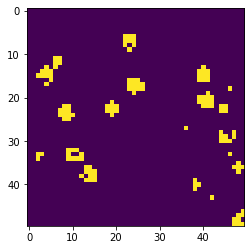

In [181]:
im=image_evol[0]
mask=Apply_thresh(im,3)
plt.imshow(mask)

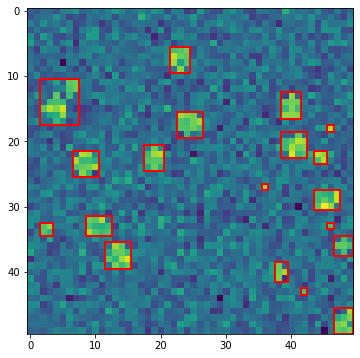

In [182]:
rois=ROI(im,mask)

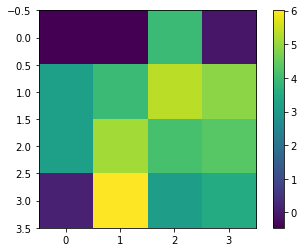

In [183]:
cluster_number=5
ti=0
plt.imshow(cluster(rois,image_evol,cluster_number,ti))
plt.colorbar()

Text(0.5, 1.0, 'Time evolution: cluster 5')

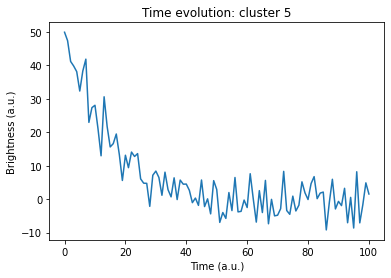

In [184]:
plt.plot(cluster_evol(rois,image_evol,cluster_number))
plt.xlabel('Time (a.u.)')
plt.ylabel('Brightness (a.u.)')
plt.title('Time evolution: cluster {}'.format(cluster_number))